{'Sent': [27113], 'Opens': [1795], 'Individual Opens': [1475]} {'subject_line': 'Win more deals with mobile data you control in real-time', 'company': 'Jola'}
['#009fe3', '#000000']


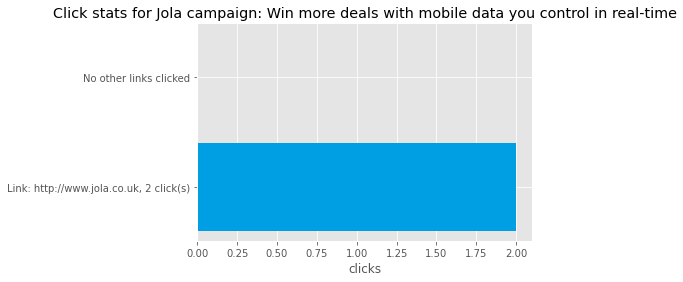

In [20]:
from math import inf
import os
import requests as req
from bs4 import BeautifulSoup
import pandas as pd
import glob
from datetime import timedelta
from datetime import date
import datetime
import matplotlib.pyplot as plt 
import csv
import shutil

plt.style.use('ggplot')

credentials ={
    'ite': {
        'password':'ITCrowdRules!',
         'url': 'https://iteuropa.circdata-solutions.co.uk/Fusion/login.aspx',
         '__VIEWSTATE' : '/wEPDwUKMTgwMjQwMDI5M2Rksovo2zHemSveuJw8vAuQ6Xf8InA=',
         '__EVENTVALIDATION' : '/wEWBQKPgenHBQLj+sxGAuOoubQBAqqg8cUOAteSgYoCZ204OWUV6uw8bUTN6GYNlbZWM7E=',
        'bot_links':['https://www.iteuropa.com/privacy-policy?ref=email_footer','https://www.iteuropa.com/?utm_source=newsletter&utm_medium=email&utm_campaign=weekly&utm_content=pixel','mailto:clients@ite-mail1.com', 'http://www.iteuropa.com', 'https://www.iteuropa.com?ref=email_footer','http://www.iteuropa.com/?q=privacy-policy','http://www.iteuropa.com/','http://www.iteuropa.com/communication-preferences?email=[CD|emailaddress|]']
        },
    'bpl':  {
        'password':'Acumagic10', 
        'url': 'https://bpl.circdata-solutions.co.uk/Fusion/login.aspx',
        '__VIEWSTATE':'/wEPDwUKMTgwMjQwMDI5M2Rk2e1SYhd3ZcfIKWr+jOok9jgKqtU=',
        '__EVENTVALIDATION':'/wEWBQLV2djbAQLj+sxGAuOoubQBAqqg8cUOAteSgYoC7owPjxk9TLLjh/iR0zoJPMA+4Yk=',
        'bot_links':['http://www.bpl-business.com','https://www.bpl-business.com', 'http://www.bpl-business.com/privacy-policy.shtml','https://www.bpl-business.com/privacy-policy','mailto:weeklynews@bpl-mail1.co.uk','https://www.fibreprovider.net/?utm_source=newsletter&utm_medium=email&utm_campaign=weekly&utm_content=pixel']
        
}
}

username = 'jubah@bpl-business.com'
company = 'ite'
stats_url = 'https://iteuropa.circdata-solutions.co.uk/Fusion/Dynamail/MailshotDetails.aspx?id=93ae286c-b7cb-4485-a997-562742a78f28'

clients = {
    'Union Street': ['#00509f', '#e6aaaa'],
    'Akixi': ['#035496', '#efc52f'],
    'Fibre Provider': ['#ef7b2f', '#1f2937'],
    'Managed Services': ['#e8653f','#2d2d2d'],
    'Comms Dealer Weekly': ['#274083','#b2b2b8'],
    'Jola':['#009fe3','#000000']
}

handicap = 1


def clear_directories():
    shutil.rmtree(f'{os.getcwd()}\\company')
    shutil.rmtree(f'{os.getcwd()}\\pixels')

def isBannedCharacter(character):
    if ord(character) >= 128:
        return True

def remove_characters(string):
    unallowed = ['#', '<', '>', '%', '&', '{', '}', '/', '$', '!', '\'', '\"', ':', '@','*','?','\\','+','+','`','|','=','–' ]
    sanitised_string =''
    for character in range(len(string)):
        if not string[character] in unallowed and not isBannedCharacter(string[character]):
            sanitised_string = sanitised_string + string[character]
    return sanitised_string


def analysis_and_visualisation(company, subject_line, colours, generic_df, handicap):
    
    year = date.today().year
    month = date.today().month
    day = date.today().day
    time_stamp = f"{day}-{month}-{year}"

    path = os.getcwd()
    pixels_path = path + "\\pixels"
    company_path = path + "\\company"

    pixel_files = glob.glob(os.path.join(pixels_path, "*.csv"))
    comp_files = glob.glob(os.path.join(company_path, "*.csv"))



    df_px = pd.concat((pd.read_csv(file, parse_dates=[1,2,4],index_col=False) for file in pixel_files), ignore_index=True)
    df_comp = pd.concat((pd.read_csv(file, parse_dates=[1,2,4],index_col=False) for file in comp_files), ignore_index=True)
    #grab all files
    #########################################################################################################


    #########################################################################################################
    df = df_comp[~df_comp.Email.isin(df_px.Email)].reset_index(drop=True)

    if df.empty:
        end=''
        print('dataframe is empty - no clicks')
    else:
    
        #Remove pixel emails from the main dataframe
        #########################################################################################################


        listed_columns = list(df.columns)
        df.drop(df.columns[listed_columns.index('BounceDate'):], axis=1, inplace=True)
        #(
        # The lambda function can be used to modify the whole df.
        # The lambda function takes an arg (x) and we can give it every row and in the sense we end up processing the whole df
        # 
        # )

        #########################################################################################################

        df['Company'] = df.apply(lambda row: row.Email.split('@')[1][: row.Email.split('@')[1].index('.')], axis=1) 
        
        #Here we are adding a new column 'company' that will let us track bot companies
        #########################################################################################################


        df['name'] = df.apply(lambda row: row.Email.split('@')[0].lower(), axis=1) 
        fake_people = ['info', 'sales', 'marketing', 'operations','hello']

        df = df[~df.name.isin(fake_people)].reset_index(drop=True)

        people_clicks = {}

        for person in df.Email:
            clicks = df[df.Email == person].LinkClickedDate.reset_index(drop =True)
        
            people_clicks[person] = clicks

        #########################################################################################################

        
        #get clickers that clicked too quickly
        bots = []
        bot_companies = ['bpl-business']
        for clicker in people_clicks:
            clicks = list(people_clicks[clicker])
            clicks.sort()
            

            
            too_soon = timedelta(seconds=handicap)
            shortest_time = timedelta(seconds=-1)

            length = len(clicks)
            if length:
                for i in range(length-1):
                    gap = clicks[i+1]- clicks[i]
                
                    if (gap > shortest_time and gap <= too_soon):
                        if not clicker in bots:
                            bots.append(clicker)

                        comp = df[df.Email == clicker].Company.reset_index(drop=True)[0] 
                        if not comp in bot_companies:
                            bot_companies.append(comp)

                        

        
        

        sanitised = df[~df.Email.isin(bots) & ~df.Company.isin(bot_companies)].reset_index(drop=True)

        ##make holding directories

        parent_dir = f"{os.getcwd()}\\Completed_Reports"
        

        dir_path = f"{os.getcwd()}\\Completed_Reports\\{company}"

        dir_exists = os.path.isdir(dir_path)

        if not dir_exists:
            os.mkdir(dir_path)
        os.mkdir(f"{os.getcwd()}\\Completed_Reports\\{company}\\{subject_line}")
        dir_path = f"{os.getcwd()}\\Completed_Reports\\{company}\\{subject_line}"
            
        sanitised.to_csv(f"{dir_path}\\{subject_line}-clickStats.csv",index=False)
        generic_df.to_csv(f'{dir_path}\\{subject_line}-genericStats.csv', index=False)

        links = {}
        for link in sanitised.LinkUrl:
            if link in links:
                links[link] +=1
            else:
                links[link] =1


        links_Y = []
        links_Xticks = []
        color_scheme =[]
        colors = colours
        index = 0



        for x in links:
            label = x
            links_Xticks.append(f"Link: {label}, {links[x]} click(s)")
            links_Y.append(links[x])
            if index % 2 ==0:
                color_scheme.append(colors[0])
            else:
                color_scheme.append(colors[1])
            index +=1

        if (len(links)<2):
            links_Xticks.append(f"No other links clicked")
            links_Y.append(0)
            color_scheme.append(colors[1])


        print(color_scheme)
        plt.barh(links_Xticks, links_Y, color=color_scheme)
        plt.title(f'Click stats for {company} campaign: {subject_line}')
        plt.xlabel('clicks')
        plt.savefig(f"{dir_path}\\{subject_line}-ecast-stats.pdf", bbox_inches = 'tight')
        plt.show()


def get_basic_info(company, stats_url):

    ## Login to dynamail
    webpage_response = req.get(credentials[company]['url'])
    webpage = webpage_response.content
    # login_page = BeautifulSoup(webpage,'html.parser')

        ##login input fields

    login_creds = {
        'ctl00$CPHP$newloginControl$tbUsername': username,
        'ctl00$CPHP$newloginControl$tbPassword': credentials[company]['password'],
        'ctl00$CPHP$newloginControl$loginButton': 'Login',
        '__VIEWSTATEGENERATOR': '5E82A05A',
        '__VIEWSTATE': credentials[company]['__VIEWSTATE'],
        '__EVENTVALIDATION': credentials[company]['__EVENTVALIDATION'],
    }

    session = req.session()
    res = session.post(credentials[company]['url'], data=login_creds)


    ####################################################################
    #   Go to specific url#######
    stats_page = session.get(stats_url)
    stats_page_soup = BeautifulSoup(stats_page.content, 'html.parser')


    generic_stats ={
        'Sent': [0],
        'Opens':[0],
        'Individual Opens':[0]
    }

    client_info = {
        'subject_line': '',
        'company':''
    }


    ####get total_Sent
    labels = stats_page_soup.find_all(attrs={'class':'Label'})

    for x in labels:

        if(x.string.find('Emails') > 0):   
            generic_stats['Sent'][0] = int(x.parent.find_all('td')[1].find('a').string)
        if(x.string.find('Subject') > 0):
            client_info['subject_line'] = x.parent.find_all('td')[1].string
        if(x.string.find('Campaign') > 0):
            client_info['company'] = x.parent.find_all('td')[1].find('a').string
        

    ##### get opened and unique opens
    unique_opens_img = stats_page_soup.find('img', attrs={'id': 'ctl00_CPHP_mailshotCharts_EmailsByStatusChart_Chart1'}).parent.find_all('area')[1].attrs['title']
    unique_opens = int(unique_opens_img[unique_opens_img.index('- ')+1:])
    generic_stats['Individual Opens'][0] = unique_opens

    overall_opens = int(stats_page_soup.find('span', attrs={'id':'ctl00_CPHP_mailshotCharts_OpenedEmailsLabel'}).find('b').text)
    generic_stats['Opens'][0] = overall_opens

    ### santise subject line and subject_line
    start_slice = inf
    end_slice = None
    for x in client_info['subject_line']:
        if(x != ' ' and x !='\n' and x != '\r\n' and x != '\r'):
            end_slice = client_info['subject_line'].rindex(x)
            if(client_info['subject_line'].index(x) < start_slice):
                start_slice = client_info['subject_line'].index(x)
    client_info['subject_line'] = remove_characters(client_info['subject_line'][start_slice:end_slice+1])


    ### santise company and subject_line
    start_slice = inf
    end_slice = None
    for x in client_info['company']:
        if(x != ' ' and x !='\n' and x != '\r\n' and x != '\r'):
            end_slice = client_info['company'].rindex(x)
            if(client_info['company'].index(x) < start_slice):
                start_slice = client_info['company'].index(x)
    client_info['company'] = remove_characters(client_info['company'][start_slice:end_slice+1])

    generic_df = pd.DataFrame(generic_stats)
    
    

    print(generic_stats, client_info)

    clicks_table = stats_page_soup.find('table', attrs={'class':'PlainTable'}).find_all('tr')

    individual_clicks = {
        'pixels':[],
        'company':[]
    }
    for index in range(1, len(clicks_table)):
        row = clicks_table[index]
        sections = row.find_all('td')
        
        link_clicked = sections[1]
        link_clicked_href = link_clicked.find('a').get('href')

        click_stats_link = sections[2].find('a').get('href')


        # print(sections[1].find('a').get('href'))
        if link_clicked_href in credentials[company]['bot_links']:
            if not click_stats_link in individual_clicks['pixels']:
                individual_clicks['pixels'].append(click_stats_link)
        else:
            if not click_stats_link in individual_clicks['company']:
                individual_clicks['company'].append(click_stats_link)

    os.mkdir(f'{os.getcwd()}\\company')
    os.mkdir(f'{os.getcwd()}\\pixels')
    for index in range(len(individual_clicks['pixels'])):
        link = individual_clicks['pixels'][index]
        click_stats_res = session.get(link)
        click_stats_page = BeautifulSoup(click_stats_res.content, 'html.parser')
        form = click_stats_page.find('form')
        inputs = form.find_all('input')
        input_dictionary={}
        for x in inputs:
           name= x.get('name')
           value = x.get('value')
           if(name != None and not name in input_dictionary):
            input_dictionary[name]=value
        csv_data = session.post(link, data=input_dictionary)
        newFile = open(f'{os.getcwd()}\\pixels\\Recipients({index}).csv', 'w', newline='')
        newFile.write(csv_data.text)
        newFile.close()

    for index in range(len(individual_clicks['company'])):
        link = individual_clicks['company'][index]
        click_stats_res = session.get(link)
        click_stats_page = BeautifulSoup(click_stats_res.content, 'html.parser')
        form = click_stats_page.find('form')
        inputs = form.find_all('input')
        input_dictionary={}
        for x in inputs:
           name= x.get('name')
           value = x.get('value')
           if(name != None and not name in input_dictionary):
            input_dictionary[name]=value
        csv_data = session.post(link, data=input_dictionary)
        newFile = open(f'{os.getcwd()}\\company\\Recipients({index}).csv', 'w', newline='')
        newFile.write(csv_data.text)
        newFile.close()


    ##run analysis
    if client_info['company'] in clients:
        analysis_and_visualisation(subject_line=client_info['subject_line'], company=client_info['company'], colours=clients[client_info['company']], generic_df=generic_df, handicap=handicap)
    else:
        print(f'To run analysis please provide colours for the company: {client_info["company"]}')
get_basic_info(company, stats_url=stats_url)
# clear_directories()






